<a href="https://colab.research.google.com/github/KhadidjaHbl/BUSTRACKER/blob/master/Lstm_sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import re
import nltk
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.models import load_model
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
ar_stopwords = '''
أنفسنا مثل حيث ذلك بشكل لدى ألا عن إلي ب لنا وقالت فقط الذي الذى ا هذا غير أكثر اي أنا أنت ايضا اذا كيف وكل أو اكثر أي أن منه وكان وفي تلك إن سوف حين نفسها هكذا قبل حول منذ هنا عندما على ضمن لكن فيه عليه قليل صباحا لهم بان يكون بأن أما هناك مع فوق بسبب ما لا هذه و فيها ف ولم ل آخر ثانية انه من الان جدا به بن بعض حاليا بها هم أ كانت هي لها نحن تم أنفسهم ينبغي إلى فان وقد تحت' عند وجود الى فأن الي او قد خارج إنه اى مرة هؤلاء أنها إذا فهي فهى كل يمكن جميع أنفسكم فعل كان ثم لي الآن وقال فى في ديك لم لن له تكون الذين ليس التى التي أنه وان بعد حتى ان دون وأن لماذا يجري كلا إنها لك ضد وإن فهو انها منها أى لديه ولا بين خلال وما اما عليها بعيدا كما نفسي نحو هو نفسك نفسه انت ولن إضافي لقاء وكانت هى فما أيضا إلا معظم ومن إما الا بينما وهي وهو وهى
'''

ar_stopwords=nltk.word_tokenize(ar_stopwords)
print("length of stopwords is: ",len(ar_stopwords))


length of stopwords is:  179


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
def process_text(text):
    stemmer = nltk.ISRIStemmer()
    word_list = nltk.word_tokenize(text)
    #remove arabic stopwords
    word_list = [ w for w in word_list if not w in ar_stopwords ]
    #remove digits
    word_list = [ w for w in word_list if not w.isdigit() ]
    #stemming
    word_list = [stemmer.stem(w) for w in  word_list]
    return ' '.join(word_list) 


def clean_text(text):  

    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
    #remove tashkeel
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
  
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)
    #remove english words
    text = re.sub(r"[a-zA-Z]", '', text)
    #remove spaces
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    #remove repetetions
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    text = text.strip()
    
    return process_text(text) 


In [6]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from pathlib import Path
path = Path('/content/drive/MyDrive/Colab Notebooks/Dataset')
data = pd.read_csv(path/'AraCOVID19-SSD_V1.0_with_text.csv', ";")
data["sarcasm"]=data["Sarcastic"]
data["tweet"]= data["Tweet_Text"]
data= data[["sarcasm","tweet"]] #colomns in ArSarcasm_train
# exclude nutral sentiments
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,sarcasm,tweet
0,No,#الغاء_الاختبارات_النهاييه #كورونا_السعوديه #كورونا وتَضِيق دُنيانَا فَنحسبُ أنَّنا .. سَنموتُ يأسًا أو نموتُ نحِيبا وإِذا بلُطفِ الله يهطلُ فجْأةً .. يُربِي منَ اليَبسِ الفُتاتِ قلُوبا
1,Yes,*علاج ڤايروس الكورونا* كل يوم الصبح الواحد يقرط ثلات حبات ثوم، ومع إنو الثوم ما إله علاقة بڤايروس الكورونا بس هكذا بتضمن لا حدا يقرب عليك ولا حدا يبوسك . 😅😅😅 😂😂😂 الله يبعد مننا ومنكم البلاء يارب
2,Yes,ههههه هذا مكان اخطر من كورونا فايروس. 😂😂🔥.
3,No,من قلب الحجر الصحي 👇👇👇 و الله مانا حابسييين 🎶🎵🎶🎶🇩🇿🇩🇿🇩🇿 #الحراك_مستمر #الحراك_الشعبي #الجزائر #دولة_مدنية_ماشي_عسكرية #الثورة_مستمرة #كورونا_فيروس #بوصبع https://t.co/XgqAhXuVyc
4,No,وحشني ابويي 😭😭 الله يلعن كورونا 😩


In [8]:
data['cleaned_text'] = data.tweet.apply(clean_text)
data = data[data.cleaned_text != ""]
data.head(10)

,sarcasm,tweet,cleaned_text
0,No,#الغاء_الاختبارات_النهاييه #كورونا_السعوديه #كورونا وتَضِيق دُنيانَا فَنحسبُ أنَّنا .. سَنموتُ يأسًا أو نموتُ نحِيبا وإِذا بلُطفِ الله يهطلُ فجْأةً .. يُربِي منَ اليَبسِ الفُتاتِ قلُوبا,غاء خبر نهي كورو سعد كورو تضق دنا حسب انن نمو يسا نمت نحب وذا لطف الل هطل فجه يرب يبس فتت قلب
1,Yes,*علاج ڤايروس الكورونا* كل يوم الصبح الواحد يقرط ثلات حبات ثوم، ومع إنو الثوم ما إله علاقة بڤايروس الكورونا بس هكذا بتضمن لا حدا يقرب عليك ولا حدا يبوسك . 😅😅😅 😂😂😂 الله يبعد مننا ومنكم البلاء يارب,علج ڤايروس كورو يوم صبح وحد قرط ثلت حبت ثوم ومع انو ثوم اله علق ڤايروس كورو بس تضم حدا قرب علك حدا يبس الل بعد ننا ومن بلء يرب
2,Yes,ههههه هذا مكان اخطر من كورونا فايروس. 😂😂🔥.,هه كان خطر كورو يرس
3,No,من قلب الحجر الصحي 👇👇👇 و الله مانا حابسييين 🎶🎵🎶🎶🇩🇿🇩🇿🇩🇿 #الحراك_مستمر #الحراك_الشعبي #الجزائر #دولة_مدنية_ماشي_عسكرية #الثورة_مستمرة #كورونا_فيروس #بوصبع https://t.co/XgqAhXuVyc,قلب حجر صحي ولل انا حبس حرك سمر حرك شعب جزر دول دنه اشي عسكر ثور مره كورو يرس صبع
4,No,وحشني ابويي 😭😭 الله يلعن كورونا 😩,وحش ابي الل يلع كورو
5,No,عاجل | وزير الصحة الدكتور باسل الصباح : أعزي نفسي وكل الزملاء بوفاة الأخ/ د. طارق حسين مخيمر ، من أطباء الأنف والأذن والحنجرة في م. زين متأثرا بمضاعفات فيروس كورونا المستجد. رحمه الله وألهم أهله ومحبيه الصبر والسلوان.,عجل وزر صحه دكتور بسل صبح اعز زملاء بوف الخ د طرق حسن خيمر طبء انف اذن حنجر م زين تثر ضعف يرس كورو سجد رحم الل وال اهل محب صبر سلو
6,No,لمن اضطرّ للخروج من المنزل تأكد من اتباع الخطوات التالية لحماية نفسك و عائلتك من فيروس #كورونا. #الأردن_اليوم #خليك_بالبيت #كورونا_الأردن https://t.co/T6xsJgumfK,لمن ضطر خرج نزل تكد تبع خطو اله لحم وعل يرس كورو ارد اليوم خلك بيت كورو ارد
7,Yes,بسبب كورونا الصين🇨🇳 : لا خروج من المنزل ايطاليا🇮🇹 : لا دراسة لا عمل لا رياضه السعودية🇸🇦 : لا حج لا عمرة ليبيا 🇱🇾 : خالق الرأس قاطعة,كورو صين خرج نزل يطل درس عمل ريض سعد حج عمر ليب خلق راس قطع
8,Yes,خايفه يجيبوا لقاح الكورونا وما يكفينا ويقوموا يزيدوه مي ويخضوا العلبه. الاردن وبعرفها 🙂🥲💔,خيف يجب لقح كورو يكف يقم زيدو مي يخض علب ارد عرف
9,Yes,@interieur_dz احموا البلاد من وباء الامازيغية و القبايل الزواف لانهم اخطر من كورونا,احم بلد وبء امازيغيه قبيل زوف لان خطر كورو


In [9]:
from sklearn.preprocessing import LabelEncoder

X = data.cleaned_text.values #training paramter
data.sarcasm = LabelEncoder().fit_transform(data.sarcasm)
Y = np.asarray(data.sarcasm.values).astype('float32') #prediction paramter
Y = Y.clip(0, 1)

In [10]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
print("vocab size:",len(tokenizer.word_index))
X = pad_sequences(X, padding='post', maxlen=300)

vocab size: 5192


In [11]:
X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("Training:", len(X_train))
print("Testing: ", len(X_test))

Training: 3613
Testing:  1549


In [12]:
#create LSTM model with keras
embedding_dim = 100
dropout = 0.5
opt = 'adam'
clear_session()
model = Sequential()
model.add(layers.Embedding(input_dim=20000, 
                           output_dim=100, 
                           input_length=300))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.5, 
                                           recurrent_dropout=0.5, 
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         160800    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [14]:
history = model.fit(X_train, label_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, label_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss_val, accuracy_val = model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/10
57/57 [==============================] - 138s 2s/step - loss: 0.6545 - accuracy: 0.6377 - val_loss: 0.6180 - val_accuracy: 0.6546
Epoch 2/10
57/57 [==============================] - 148s 3s/step - loss: 0.4682 - accuracy: 0.7575 - val_loss: 0.2088 - val_accuracy: 0.9458
Epoch 3/10
57/57 [==============================] - 150s 3s/step - loss: 0.2161 - accuracy: 0.9419 - val_loss: 0.1802 - val_accuracy: 0.9296
Epoch 4/10
57/57 [==============================] - 139s 2s/step - loss: 0.1410 - accuracy: 0.9579 - val_loss: 0.1013 - val_accuracy: 0.9671
Epoch 5/10
57/57 [==============================] - 138s 2s/step - loss: 0.0914 - accuracy: 0.9759 - val_loss: 0.1241 - val_accuracy: 0.9600
Epoch 6/10
57/57 [==============================] - 138s 2s/step - loss: 0.0650 - accuracy: 0.9820 - val_loss: 0.1570 - val_accuracy: 0.9619
Epoch 7/10
57/57 [==============================] - 138s 2s/step - loss: 0.0473 - accuracy: 0.9873 - val_loss: 0.1814 - val_accuracy: 0.9567
Epoch 8/10
57

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


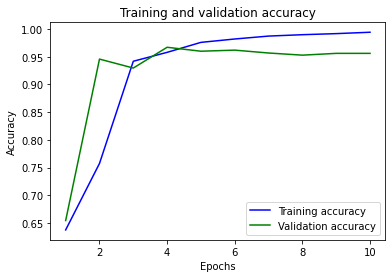

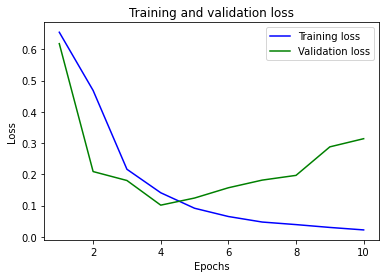

In [16]:
plot_history(history)

In [24]:
#save model
model.save('model.h5')

In [36]:
def predict(input):
  input=clean_text(input)
  model_input=tokenizer.texts_to_sequences(input)
  model_input=pad_sequences(model_input, padding='post', maxlen=300)
  pred = model.predict(model_input, verbose=True)
  pred=pred.reshape(pred.shape[0],)[0]
  if(pred>0.5): return "Sarcastique",pred
  return "non-sarcastique",pred
predi=predict("48670715 _ من سنة 92 بدأت الكتابة ضد إستبداد مبارك وضد التطرف الديني أيضا وماكانتش لسه المعارضة رخيصة وبتلم")
predi

2/2 [==============================] - 1s 290ms/step


('Sarcastique', 0.93350506)